# Alpha Model: LSTM Network

In [1]:
# Importing Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import quandl
from config import API_KEY
%matplotlib inline

In [2]:
# Establishing API key
quandl.ApiConfig.api_key = API_KEY

# Data Exploration

Let's make a function that grabs stock info from Quandl's APIs.

In [3]:
def grab_data(ticker, start='2016-01-15', end='2019-01-15'):
    return quandl.get(f'WIKI/{ticker}', start_date=start, end_date=end)

Now we'll grab Tesla's stock info and explore our data.

In [4]:
TSLA = grab_data('TSLA')
TSLA.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-15,198.9700,205.07,197.25,204.99,5578640.0,0.0,1.0,198.9700,205.07,197.25,204.99,5578640.0
2016-01-19,208.7100,210.47,200.78,204.72,4038676.0,0.0,1.0,208.7100,210.47,200.78,204.72,4038676.0
2016-01-20,199.4000,201.28,191.25,198.70,5838608.0,0.0,1.0,199.4000,201.28,191.25,198.70,5838608.0
2016-01-21,201.5500,203.23,195.02,199.97,3166159.0,0.0,1.0,201.5500,203.23,195.02,199.97,3166159.0
2016-01-22,204.8005,205.50,199.03,202.55,3124055.0,0.0,1.0,204.8005,205.50,199.03,202.55,3124055.0


Here are some stats per column:

In [5]:
TSLA.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,552.000000,552.000000,552.000000,552.000000,5.520000e+02,552.0,552.0,552.000000,552.000000,552.000000,552.000000,5.520000e+02
mean,270.285381,274.272146,265.950903,270.171209,5.510025e+06,0.0,1.0,270.285381,274.272146,265.950903,270.171209,5.510025e+06
std,62.665753,63.165573,61.802643,62.507392,2.761287e+06,0.0,0.0,62.665753,63.165573,61.802643,62.507392,2.761287e+06
min,142.320000,154.970000,141.050000,143.670000,1.659530e+06,0.0,1.0,142.320000,154.970000,141.050000,143.670000,1.659530e+06
25%,213.067500,216.315000,208.955000,213.910000,3.755836e+06,0.0,1.0,213.067500,216.315000,208.955000,213.910000,3.755836e+06
50%,254.075000,258.280000,250.755000,254.895000,4.889156e+06,0.0,1.0,254.075000,258.280000,250.755000,254.895000,4.889156e+06
75%,329.400000,333.150000,323.289475,328.527500,6.491168e+06,0.0,1.0,329.400000,333.150000,323.289475,328.527500,6.491168e+06
max,386.690000,389.610000,379.345000,385.000000,2.374241e+07,0.0,1.0,386.690000,389.610000,379.345000,385.000000,2.374241e+07


Let's try and see what our closing prices have looked like over the past three years.

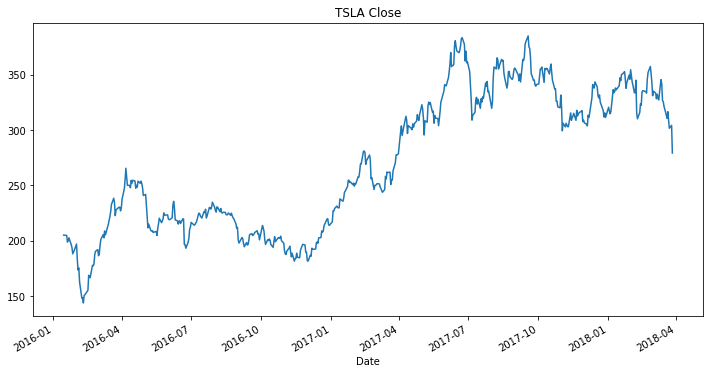

In [27]:
closing_TSLA = TSLA['Close']
closing_TSLA.plot(figsize=(12, 6), title='TSLA Close');

# Machine Learning

Now that we've explored our dataset, let's try to train an LSTM network to predict Tesla's future stock prices based on its closing prices of the past.

In [28]:
# importing from ML libraries
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
# from keras.layers import Flatten
from sklearn.metrics import mean_squared_error

## Preprocessing

We'll create a function that will separate our dataset into an X and y array, where X is the closing price on day i and y is the closing price on i + 1.

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(7)

Now we'll grab our data and sort it so that it's in correct order. We'll also change its values data type.

In [9]:
closing_TSLA_df = pd.DataFrame(closing_TSLA)
closing_TSLA_df.sort_index(ascending=True, axis=0, inplace=True)

In [10]:
dataset = closing_TSLA_df.values.astype('float32')

Luckily for us, Sci-Kit Learn has an easy to use scaler so that we can remove any skewness from our data while still maintaining the important information.

In [11]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

We'll split our data set into a training and testing set, then pop them into our function earlier so that we can get an X and y for each subset. After that, we can reshape our data to prepare it for our LSTM model.

In [12]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# create datasets by pushing out X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Forecasting Model

Since we're working with sequential data, we'll use a sequential model from Keras and create an LSTM block within its layers.
Then, we'll fit our data to our training set over 100 epochs.

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0698
Epoch 2/100
 - 2s - loss: 0.0224
Epoch 3/100
 - 2s - loss: 0.0151
Epoch 4/100
 - 2s - loss: 0.0082
Epoch 5/100
 - 2s - loss: 0.0034
Epoch 6/100
 - 2s - loss: 0.0012
Epoch 7/100
 - 2s - loss: 6.4172e-04
Epoch 8/100
 - 2s - loss: 5.6802e-04
Epoch 9/100
 - 2s - loss: 5.6547e-04
Epoch 10/100
 - 2s - loss: 5.6393e-04
Epoch 11/100
 - 2s - loss: 5.6176e-04
Epoch 12/100
 - 2s - loss: 5.5949e-04
Epoch 13/100
 - 2s - loss: 5.5515e-04
Epoch 14/100
 - 2s - loss: 5.7185e-04
Epoch 15/100
 - 2s - loss: 5.7484e-04
Epoch 16/100
 - 2s - loss: 5.6644e-04
Epoch 17/100
 - 2s - loss: 5.5900e-04
Epoch 18/100
 - 2s - loss: 5.6522e-04
Epoch 19/100
 - 2s - loss: 5.3994e-04
Epoch 20/100
 - 2s - loss: 5.5735e-04
Epoch 21/100
 - 2s - loss: 5.6424e-04
Epoch 22/100
 - 2s - loss: 5.5528e-04
Epoch 23/100
 - 2s - loss: 5.4392e-04
Epoch 24/100
 - 2s - loss: 5.9155e-04
Epoch 25/100
 - 2s - loss: 5.5347e-04
Epoch 26/100
 - 2s - loss: 5.5554e-04
Epoch 27/100
 - 2s - loss: 5.5452e-04
Epoch 2

Now let's make some predictions and inverse the transforms so that our numbers make sense.

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Conclusion

Train Score: 5.70 RMSE
Test Score: 7.42 RMSE


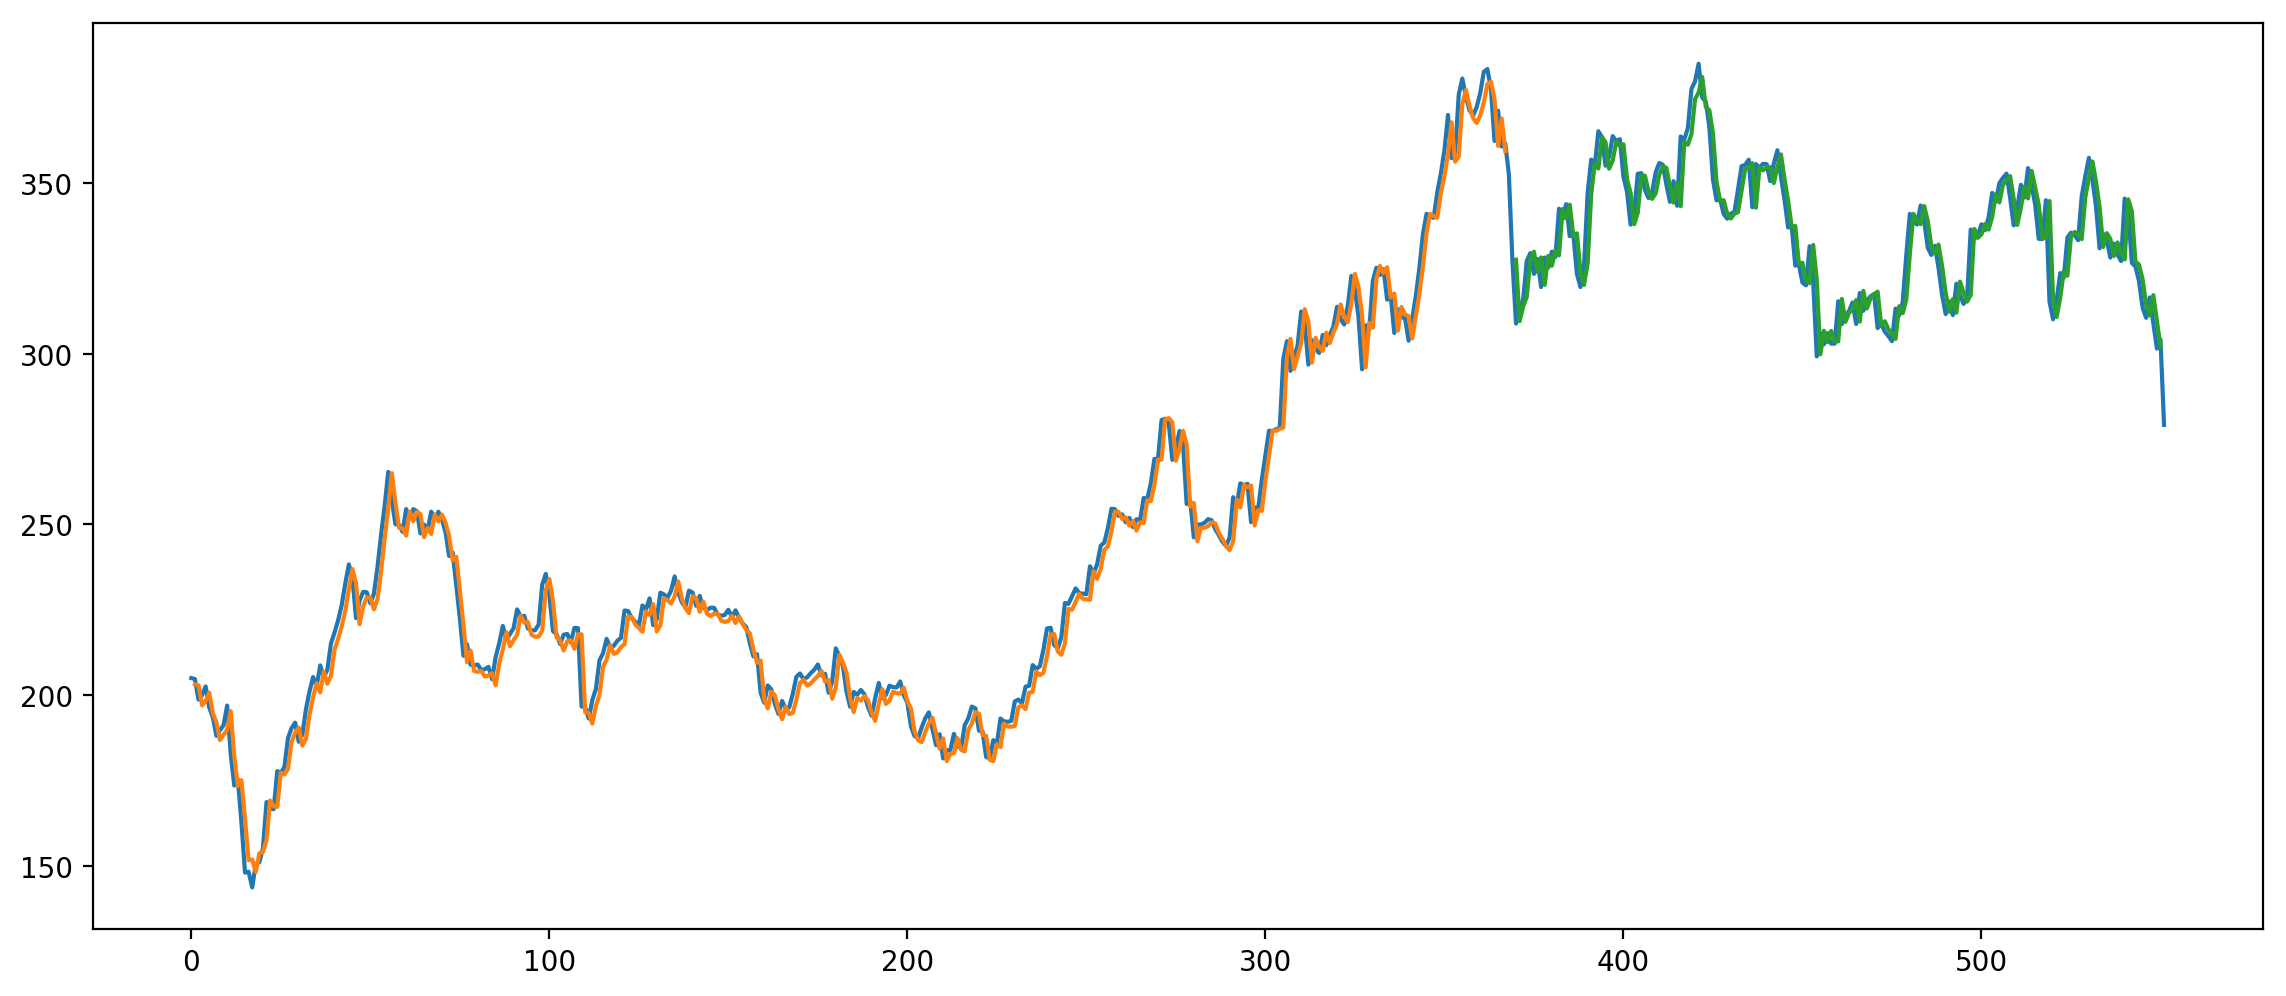

In [17]:
# calculate root mean squared error
trainScore = (mean_squared_error(trainY[0], trainPredict[:,0]) ** .5)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = (mean_squared_error(testY[0], testPredict[:,0]) ** .5)
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(num=None, figsize=(14, 6), dpi=200)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<kbd>Our original dataset is plotted in blue, our predictions for our training is in orange, and our predictions for our testing data is in green.</kbd>

It looks like our model worked very well!
The goal of this project was to develop a forecasting model that can ultimately trade on predictions on a daily basis, so we fulfilled our task.

One should keep in mind though that the main set back for this type of model is that we have to balance our predictions with the number of time steps we are willing to take.
In other words, if we wanted to look a week into the future, then we would run the risk of losing more accuracy.

To see how well our model is working, let's grab the last prediction and compare it to its corresponding closing price.

In [18]:
# Actual
closing_TSLA_df.values[-2]

array([304.18])

In [19]:
# Predicted
testPredictPlot[-2]

array([302.17935], dtype=float32)

We're a couple of dollars off, so there is still room for improvement. Let's view the actual price the day before and see if we would have profited if we used our prediction.

In [20]:
# Actual Day Before
closing_TSLA_df.values[-3]

array([301.54])

It looks like our model is headed in the right direction, but does not fully grasp the extent of the volatility that is attributed to Tesla's stock prices.

### Afterword
Although this may be the end of this final project at UCI, I will continue to expand upon this and attempt to develop an adequate trading bot over the course of the next several years, which will hopefully generate reasonable returns.

My main focus, however, will shift onto more career-oriented projects (since I hope to land a job as a software developer/data analyst after undergrad).